# Import Packages

In [ ]:
%cd /content/drive/My Drive/20FA/DataMining/HW3

In [8]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from tqdm.notebook import tqdm
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline

# "0"/"9" Data Extraction

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5)),
])
trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset)
valloader = torch.utils.data.DataLoader(valset)

In [5]:
ZeroNineTrain = [i for i in tqdm(trainset) if (i[1] == 0)|(i[1] == 9)]
X_train, y_train = zip(*ZeroNineTrain)
X_train = torch.stack(X_train)
y_train = torch.tensor(y_train)

In [6]:
ZeroNineVal = [i for i in tqdm(valset) if (i[1] == 0)|(i[1] == 9)]
X_val, y_val = zip(*ZeroNineVal)
X_val = torch.stack(X_val)
y_val = torch.tensor(y_val)

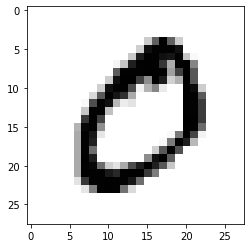

tensor(0)

In [9]:
plt.imshow(X_train[0].squeeze(), cmap="gray_r")
plt.show()
y_train[0]

In [10]:
torch.save(X_train, "X_train.pt")
torch.save(y_train, "y_train.pt")
torch.save(X_val, "X_val.pt")
torch.save(y_val, "y_val.pt")

# Class: SVM

In [29]:
class SVM():
    """ 
    SVM binary classifier, optimizing with the dual lagrangian program, 
    trained on batch. Uses the SMO algorithm.

    [CS229 - Kernel Methods and SVM](http://cs229.stanford.edu/notes2020fall/notes2020fall/cs229-notes3.pdf)

    ## Input:
        X: (N, d)
        Y: (N,)
        n = batch_size: int
        C: l1 regularization term. alpha_i in [0, C]

    ## Intermediate parameters:
        x: (n, d), random batch of X
        y: (n)
        M: (n, n), M[i,j] = y_iy_j<x_i,x_j>

    ## Learned parameters:
        alpha: (n,)
        w: (d,)
        b: int

    """

    def __init__(self, X, Y, batch_size=64, C=5):
        # X: (N,d), Y: (N,), x: (n,d), y:(n,)
        # Fixed values
        self.N, self.d = X.shape
        self.n = batch_size
        self.C = C
        self.X = X
        self.Y = Y
        self.x = self.X[:self.n]
        self.y = self.Y[:self.n]
        self.M = np.outer(self.y,self.y) * np.dot(self.x, self.x.T)

        
        # Learned parameters
        self.alpha = np.ones(self.n)
        self.w = np.zeros(self.d)
        self.b = 0
    
    def shuffle_batch(self):
        batch_indices = np.random.choice(np.arange(self.N), self.n)
        self.x = self.X[batch_indices]
        self.y = self.Y[batch_indices]
        self.M = np.outer(self.y,self.y) * np.dot(self.x, self.x.T)

    def update_alpha(self, random_idx1, random_idx2):
        Zeta = -np.sum(self.alpha*self.y) + (self.alpha*self.y)[random_idx1] + (self.alpha*self.y)[random_idx2]
        self.alpha[random_idx1] = (Zeta - self.alpha[random_idx2]*self.y[random_idx2])*self.y[random_idx1]

    def dual_obj(self, alpha):
        return np.sum(alpha) - np.sum(0.5 * self.M * np.outer(alpha,alpha))
    
    def optimize(self, iterations = 100000, tol=1e-2):
        prev_val = self.dual_obj(self.alpha)
        # The first shuffling happens at time 0
        shuffle_timepoint=0


        for i in tqdm(range(iterations)):
            self.w = np.dot(self.alpha*self.y, self.x)
            self.b = (np.max(np.dot(self.x, self.w)[self.y==-1]) + np.min(np.dot(self.x, self.w)[self.y==1])) * -0.5

            # Select 2 alphas randomly
            random_idx1, random_idx2 = np.random.choice(np.arange(0, self.n), 2)

            # The (quadratic w.r.t a2) function that scipy.optimize.minimize takes
            def optimizeWRTa2(a2):
                self.alpha[random_idx2] = a2
                self.update_alpha(random_idx1, random_idx2)
                return -self.dual_obj(self.alpha)

            # Solve optimization w.r.t a2
            a2 = self.alpha[random_idx2]
            res = minimize(optimizeWRTa2, a2, bounds=[(0,self.C)])
            a2 = res.x

            # Update a2 in alpha
            self.alpha[random_idx2] = a2
            self.update_alpha(random_idx1, random_idx2)

            # Check convergence
            if (i%100 == 1):
                if np.abs(self.dual_obj(self.alpha) - prev_val) < tol:
                    if i - shuffle_timepoint < 300:
                        print("Converges quickly after shuffling. End early.")
                        return
                    else:
                        print(f"Optimized on one batch: {self.dual_obj(self.alpha) - prev_val}, shuffling... \n")
                        self.shuffle_batch()
                        # Record the time of shuffling. If next shuffling appears soon,
                        # just end the training.
                        shuffle_timepoint = i
                        continue
                else:
                    if (i%1000 == 1):
                        print(self.dual_obj(self.alpha) - prev_val)
                    prev_val = self.dual_obj(self.alpha)



# Train & Val


In [12]:
X_train = torch.load("X_train.pt")
y_train = torch.load("y_train.pt")
X_val = torch.load("X_val.pt")
y_val = torch.load("y_val.pt")


# Criteria: Label0: +1, Label9: -1
y_train = (y_train==0)*2-1
y_val = (y_val==0)*2-1

In [35]:
# Sample data
X = X_train.squeeze().view((X_train.shape[0],-1)).numpy()
Y = y_train.numpy()

In [36]:
svm = SVM(X, Y)
svm.optimize()

10596.452697753906
22.864360900076463
-12045.66610562539
-645.094309826681
35.1945161057067
-105.23131704341928
-73.18730993853914
2.128320978891651
-0.13739681953040872
-4.030676453026244
-3.225604039375763
4.1126622499861964
0.026276751210134508
-0.07643640168448268
Optimized on one batch: -0.004814878714771723, shuffling... 

Optimized on one batch: -0.005937652458495313, shuffling... 

-0.06290097635171295
0.010442479787019017
Optimized on one batch: -0.0020271847500413984, shuffling... 

Optimized on one batch: 0.002147227212740077, shuffling... 

Optimized on one batch: 0.007473796428562454, shuffling... 

0.04198046960922795
Optimized on one batch: 0.004023325610427862, shuffling... 

Optimized on one batch: -0.0023942530588283925, shuffling... 

-0.014573761176672279
Optimized on one batch: -0.005471306713595928, shuffling... 

Optimized on one batch: -0.004258993823658304, shuffling... 

0.05877619830139519
Optimized on one batch: -0.006257004532848595, shuffling... 

-0.32733

In [37]:
Y_ = np.sign(np.dot(X, svm.w) + svm.b)

In [38]:
np.mean(Y == Y_)

0.9287398921832885

In [39]:
X_test = X_val.squeeze().view((X_val.shape[0],-1)).numpy()
Y_test = y_val.numpy()

In [40]:
np.mean(Y_test == np.sign(np.dot(X_test, svm.w) + svm.b))

0.9225741578682756